## 可视化滤波器

In [1]:
import matplotlib.pyplot as plt

def visualize_filters(model, num_filters=16):
    # 获取第一层 conv 的权重（shape: [out_channels, in_channels, k, k]）
    filters = model.conv1.weight.data.clone().cpu()

    # 如果是 RGB 输入，则 in_channels=3，做 channel 平均
    if filters.shape[1] == 3:
        filters = filters.mean(dim=1)  # → shape [out_channels, k, k]

    # 显示前 num_filters 个卷积核
    plt.figure(figsize=(10, 6))
    for i in range(num_filters):
        plt.subplot(4, 4, i + 1)
        plt.imshow(filters[i], cmap='gray')
        plt.axis('off')
        plt.title(f'Filter {i}')
    plt.tight_layout()
    plt.show()


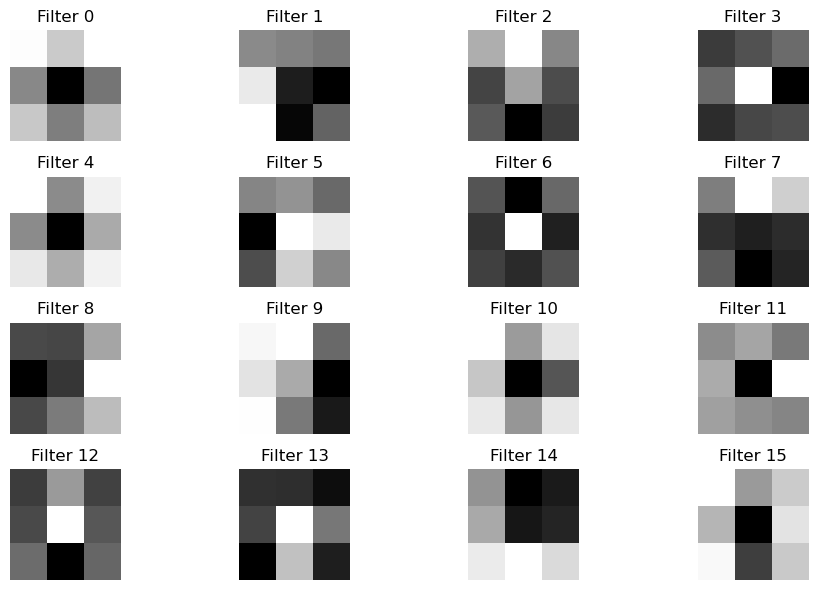

In [2]:
import model
model = model.resnet18(pretrained=True)
visualize_filters(model, num_filters=16)

## 可视化特征图

In [42]:
import torchvision
import torch
from torchvision import datasets, transforms

feature_maps = {}
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

def get_feature_hook(name):
    def hook(module, input, output):
        feature_maps[name] = output.detach().cpu()
    return hook

model.eval()
model.conv1.register_forward_hook(get_feature_hook("conv1"))

transform_test = transforms.Compose([
        transforms.Resize(32),
        transforms.CenterCrop(32),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                             std=[0.2470, 0.2435, 0.2616])
    ])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
img, label = testset[201]
print(label)
input_tensor = img.unsqueeze(0).to(device)
model(input_tensor)

Files already downloaded and verified
1


tensor([[ 1.6891, 10.6181, -1.7943, -2.8198, -3.5211, -2.5543, -2.3823, -2.7144,
         -0.0327,  3.5098]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [43]:
import matplotlib.pyplot as plt

def visualize_feature_map(feature_map, num_channels=16):
    fmap = feature_map.squeeze(0)  # shape: [C, H, W]
    plt.figure(figsize=(12, 8))
    for i in range(min(num_channels, fmap.shape[0])):
        plt.subplot(4, 4, i+1)
        plt.imshow(fmap[i], cmap='viridis')
        plt.axis('off')
        plt.title(f"Channel {i}")
    plt.tight_layout()
    plt.show()


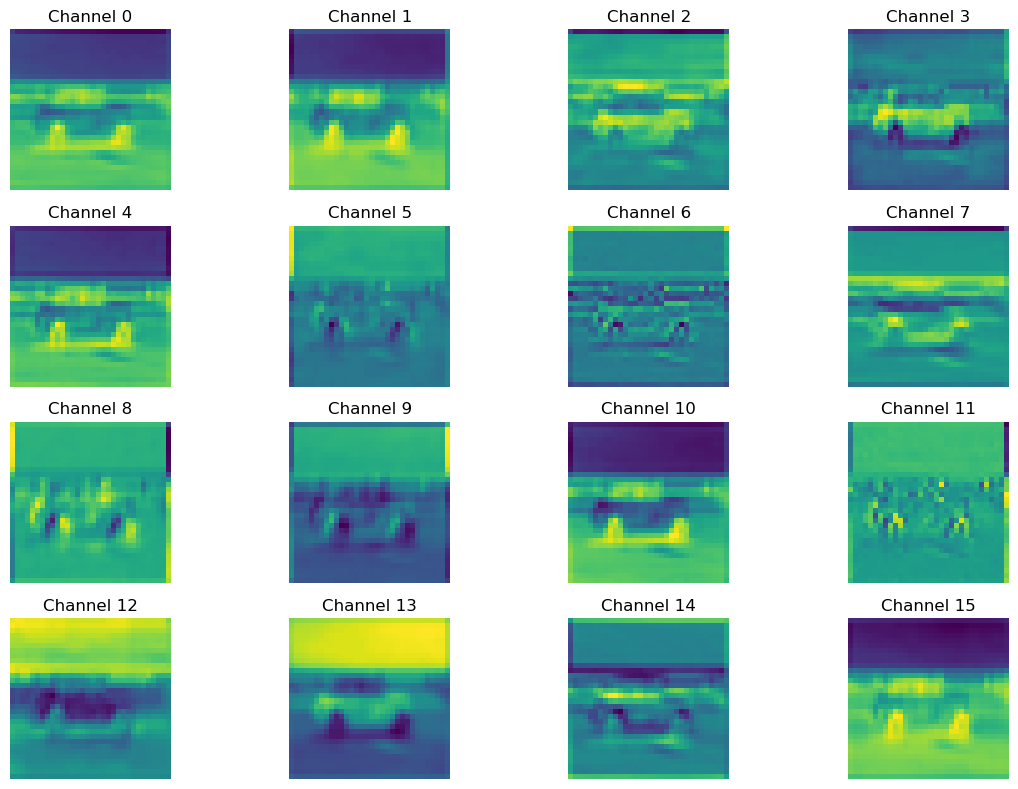

In [44]:
visualize_feature_map(feature_maps["conv1"], num_channels=16)

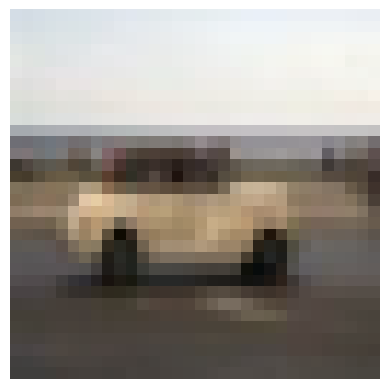

In [45]:
unnormalize = transforms.Normalize(mean=[-0.4914/0.247, -0.4822/0.243, -0.4465/0.261],
                                       std=[1/0.247, 1/0.243, 1/0.261])
def visualize_unnormalized_image(img_tensor):
    img = unnormalize(img_tensor).clamp(0, 1)
    plt.imshow(img.permute(1, 2, 0))  # 转换为 HWC 格式
    plt.axis('off')
    plt.show()
visualize_unnormalized_image(img)

## 可视化loss landscape

In [46]:
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

In [47]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def plot_loss_landscape(model, data_loader, criterion, device='cuda'):
    model.to(device)
    model.eval()

    # 获取 fc 层权重
    W = model.fc.weight.data.clone().cpu()
    direction1 = torch.randn_like(W)
    direction2 = torch.randn_like(W)

    alphas = np.linspace(-1, 1, 21)
    betas = np.linspace(-1, 1, 21)
    losses = np.zeros((len(alphas), len(betas)))

    with torch.no_grad():
        for i, alpha in enumerate(alphas):
            for j, beta in enumerate(betas):
                perturbed_weight = W + alpha * direction1 + beta * direction2
                model.fc.weight.data = perturbed_weight.to(device)

                total_loss = 0
                total = 0
                for images, labels in data_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    total_loss += loss.item() * images.size(0)
                    total += images.size(0)

                losses[i, j] = total_loss / total

    # 可视化
    plt.figure(figsize=(8, 6))
    X, Y = np.meshgrid(alphas, betas)
    plt.contourf(X, Y, losses, levels=50, cmap='viridis')
    plt.colorbar(label='Loss')
    plt.title("Loss Landscape around fc.weight")
    plt.xlabel("Direction α")
    plt.ylabel("Direction β")
    plt.show()


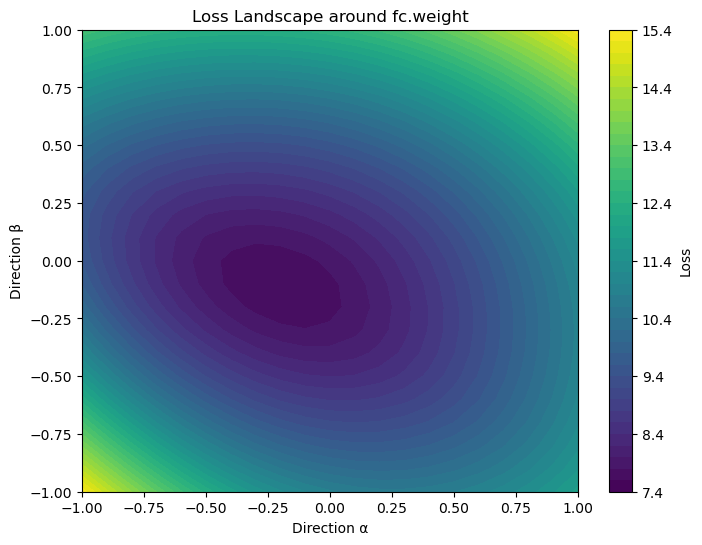

In [51]:
from torch.utils.data import DataLoader

criterion = torch.nn.CrossEntropyLoss()
subset = torch.utils.data.Subset(testset, list(range(0, 1000)))
loader = DataLoader(subset, batch_size=64, shuffle=True)
plot_loss_landscape(model, loader, criterion)